In [1]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.1 MB/s eta 0:00:00:00:01


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import requests
import tarfile
import os
import zipfile
import tempfile
import json
import librosa

2024-06-03 10:52:22.241500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 10:52:22.241627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 10:52:22.369257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import LJSpeech Dataset


*   **ID**: this is the name of the corresponding .wav files
*   **Transcription**: words spoken by the reader (UTF-8)
*   **Normalized transcription**: transcription with numbers, ordinals and monetary units expanded into full words (UTF-8).



In [3]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

2748572632/2748572632 ━━━━━━━━━━━━━━━━━━━━ 139s 0us/step


In [4]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [5]:
metadata_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [6]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [7]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "transcription", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

In [8]:
metadata_df.head(3)

,file_name,transcription,normalized_transcription
0,LJ014-0100,In the back kitchen one of the detectives rema...,In the back kitchen one of the detectives rema...
1,LJ041-0003,Return to New Orleans and Joining the Marine C...,Return to New Orleans and Joining the Marine C...
2,LJ015-0001,"Chronicles of Newgate, Volume 2. By Arthur Gri...","Chronicles of Newgate, Volume two. By Arthur G..."


Split the data into training and validation set

In [9]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 11790
Size of the validation set: 1310


# Augmentasi Data

## Preprocessing

Prepare the vocabulary to be used.

In [10]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters into integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size = 31)


Create the function that describes the transformation that we apply to each element of our dataset.

In [11]:
char_to_num

<StringLookup name=string_lookup, built=False>

In [ ]:
# An integer scalar Tensor. The window length is samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
  ###############################
  ## Process the audio
  ###############################
  # 1. Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  # 2. Decode the wav file
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio,axis=-1)
  # 3. Change type to float
  audio = tf.cast(audio, tf.float32)
  # 4. Get the spectogram
  spectogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step = frame_step, fft_length=fft_length
  )
  # 5. We only need the magnitude, which can be derived by applying tf.abs
  spectogram = tf.abs(spectogram)
  spectogram = tf.math.pow(spectogram, 0.5)
  # 6. Normalization
  means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
  spectogram = (spectogram - means) / (stddevs + 1e-10)
  ###########################
  ## Process the Label
  ###########################
  # 7. Convert label to Lower case
  label = tf.strings.lower(label)
  # 8. Split the label
  label = tf.strings.unicode_split(label,input_encoding="UTF-8")
  # 9. Map the characters in label to numbers
  label = char_to_num(label)
  # 10. Return a dict as our model is expecting two inputs
  return spectogram, label

# **STFT + MFCC Feature Extraction**

In [12]:
# An integer scalar Tensor. The window length is samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
  ###############################
  ## Process the audio
  ###############################
  # 1. Read wav file
  audio_binary = tf.io.read_file(wavs_path + wav_file + ".wav")
  audio, _ = tf.audio.decode_wav(audio_binary)
  audio = tf.squeeze(audio, axis=-1)

  # 2. Get the mel spectrogram
  stft = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
  spectrogram = tf.abs(stft)
  mel_spectrogram = tf.tensordot(spectrogram, tf.signal.linear_to_mel_weight_matrix(num_mel_bins=193, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000), 1)
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
  # 3. Normalization
  means = tf.math.reduce_mean(log_mel_spectrogram, axis=1, keepdims=True)
  stddevs = tf.math.reduce_std(log_mel_spectrogram, axis=1, keepdims=True)
  normalized_mel_spectrogram = (log_mel_spectrogram - means) / (stddevs + 1e-10)
    
  ###########################
  ## Process the Label
  ###########################
  # 4. Convert label to Lower case
  label = tf.strings.lower(label)
  # 5. Split the label
  label = tf.strings.unicode_split(label,input_encoding="UTF-8")
  # 6. Map the characters in label to numbers
  label = char_to_num(label)
  # 7. Return a dict as our model is expecting two inputs
  return normalized_mel_spectrogram, label

## Creating Dataset objects
We create a tf.data.Dataset pbject that yields the transofrmed elements, in the same order as they appeared in the input.

In [13]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls = tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

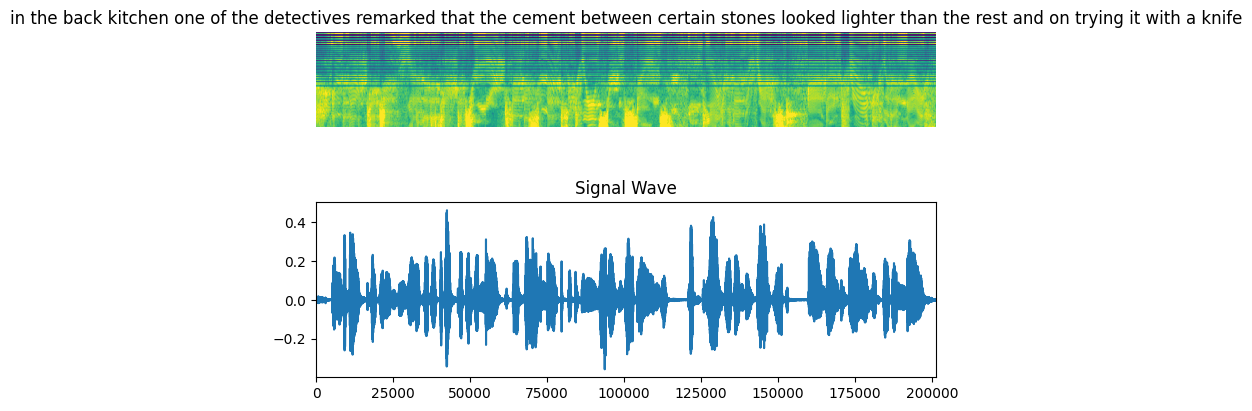

In [14]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]
  # Spectrogram
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")
  # WAV
  file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0]+ ".wav")
  audio,_ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate = 16000))
plt.show()

## Model

In [15]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

Define model similar to DeepSpeech2.

In [ ]:
# def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
#   input_spectogram = layers.Input((None, input_dim), name="input")
#   x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
#   # Convlutional layer 1
#   x = layers.Conv2D(
#       filters=32,
#       kernel_size=[11, 41],
#       strides=[2,2],
#       padding="same",
#       use_bias=False,
#       name="conv_1",
#   )(x)
#   x = layers.BatchNormalization(name="conv_1_bn")(x)
#   x = layers.ReLU(name="conv_1_relu")(x)
#   # Convlutional layer 2
#   x = layers.Conv2D(
#       filters=32,
#       kernel_size=[11, 21],
#       strides=[1,2],
#       padding="same",
#       use_bias=False,
#       name="conv_2",
#   )(x)
#   x = layers.BatchNormalization(name="conv_2_bn")(x)
#   x = layers.ReLU(name="conv_2_relu")(x)
#   x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
#   # RNN Layer
#   for i in range(1, rnn_layers + 1):
#     recurrent = layers.GRU(
#         units=rnn_units,
#         activation="tanh",
#         recurrent_activation="sigmoid",
#         use_bias=True,
#         return_sequences=True,
#         reset_after=True,
#         name=f"gru_{i}",
#     )
#     x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
#     if i < rnn_layers:
#       x = layers.Dropout(rate=0.5)(x)
#   # Dense Layer
#   x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
#   x = layers.ReLU(name="dense_1_relu")(x)
#   x = layers.Dropout(rate=0.5)(x)
#   # classification layer
#   output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
#   # model
#   model = keras.Model(input_spectogram, output, name="DeepSpeech2")
#   # optimizer
#   opt = keras.optimizers.Adam(learning_rate=1e-4)
#   # compile the model and return
#   model.compile(optimizer=opt, loss=CTCLoss)
#   return model

# model = build_model(
#     input_dim=fft_length // 2 + 1,
#     output_dim=char_to_num.vocabulary_size(),
#     rnn_units=512,
# )
# model.summary(line_length=120)

In [16]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  input_spectogram = layers.Input((None, input_dim), name="input")
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
  # Convlutional layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  # Convlutional layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1,2],
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  # RNN Layer
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
    )
    x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)
  # Dense Layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)
  # classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
  # model
  model = keras.Model(input_spectogram, output, name="DeepSpeech2")
  # optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  # compile the model and return
  model.compile(optimizer=opt, loss=CTCLoss)
  return model

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

## Training and Evaluating

In [17]:
# A utility function to decode the output of the network
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  # bisa pakai beam search juga --> untuk complex tasks
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
  # iterate over the results and get back the text
  output_text = []
  for result in results:
    result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text

# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def on_epoch_end(self, epoch: int, logs=None):
    predictions = []
    targets = []
    for batch in self.dataset:
      x, y = batch
      batch_predictions = model.predict(x)
      batch_predictions = decode_batch_prediction(batch_predictions)
      predictions.extend(batch_predictions)
      for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)
    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 2):
      print(f"Target    : {targets[i]}")
      print(f"Prediction: {predictions[i]}")
      print("-" * 100)

In [18]:
epochs = 10
validation_callback = CallbackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepstep - loss: 359.679
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


## Inference

In [19]:
# check results of validation samples
predictions = []
targets = []
for batch in validation_dataset:
  X, y = batch
  batch_predictions = model.predict(X)
  batch_predictions = decode_batch_prediction(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 2):
  print(f"Target    : {targets[i]}")
  print(f"Prediction: {predictions[i]}")
  print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# Model To JSON

# Save Model

In [ ]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

# Examine Your Saved Model

In [ ]:
!saved_model_cli show --dir {export_path} --all

# Add TensorFlow Serving Distribution URI as a Package Source

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

# Install Tensorflow Serving

In [ ]:
!apt-get install tensorflow-model-server

# Run the TensorFlow Model Server

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=speech_to_text \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

# Create JSON Object with Test Images

In [ ]:
for spectograms, labels in validation_dataset.take(1):
    # Mengonversi tensor ke list
    spectograms_list = spectograms.numpy().tolist()
    labels_list = labels.numpy().tolist()

In [ ]:
data = {
        "signature_name": "serving_default",
        "instances": spectograms_list,
        "labels": labels_list
    }

In [ ]:
json_data = json.dumps(data)

# Make Inference Request

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://192.168.1.1:8501/v1/models/digits_model:predict', data=json_data, headers=headers)

predictions = json.loads(json_response.text)['predictions']